In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


In [2]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
        self.report = self.report()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
        count = CountVectorizer()
        uidArray = self.grouped_by_productid.UserId.as_matrix()
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures
    
    def report(self):
        print(150 * '-')        
        print("Preview:", self.X)
        return self.X

In [3]:
import pandas as pd

class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]

        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))


    def print_report(self, n_samples, fileName):
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        target = open(fileName, 'w')
        
        for i in range(1, num_clusters): 
            target.write('\n')
            target.write(100 * '-')
            target.write('\n')
            target.write('cluster: %d' % i)
            target.write('\n')              
            cluster = merged.loc[merged['cluster'] == i]
            target.write(100 * '-')
            target.write('\n')            
            target.write('\n')          
            target.write('cluster size:')
            target.write(np.str(cluster.shape))
            target.write('\n')
            target.write('\n')            
            target.write(np.str(cluster.sample(n_samples)))
            target.write('\n')
            target.write('\n')            
        target.close()
        
    def viz_report(self):
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        result = []
        
        for i in range(1, num_clusters): 
            cluster = merged.loc[merged['cluster'] == i]            
            result.append(cluster.shape[0])
        plt.figure(figsize=(35,10))
        ind = np.arange(len(result))  # the x locations for the groups
        width = 1        
        plt.bar(ind + width, result, width, color='red', alpha=0.7)
        plt.ylabel('Cluster size')
        plt.xlabel('Cluster id')
        plt.xticks(ind, ind)
        plt.savefig('clusters_size.png')


In [4]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('../Amazon.csv', 4)

../Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as pictured.   
1                

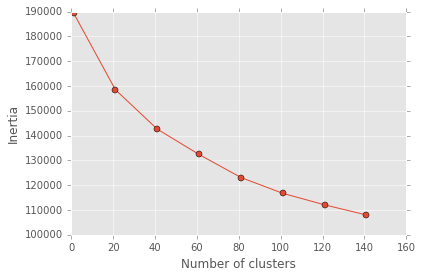

In [5]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 160, 20):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 160, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [1]:
# fit KMeans with 10 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=485, init='k-means++', n_jobs=-1)
km.fit(amazonData.X)

NameError: name 'amazonData' is not defined

In [7]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km)

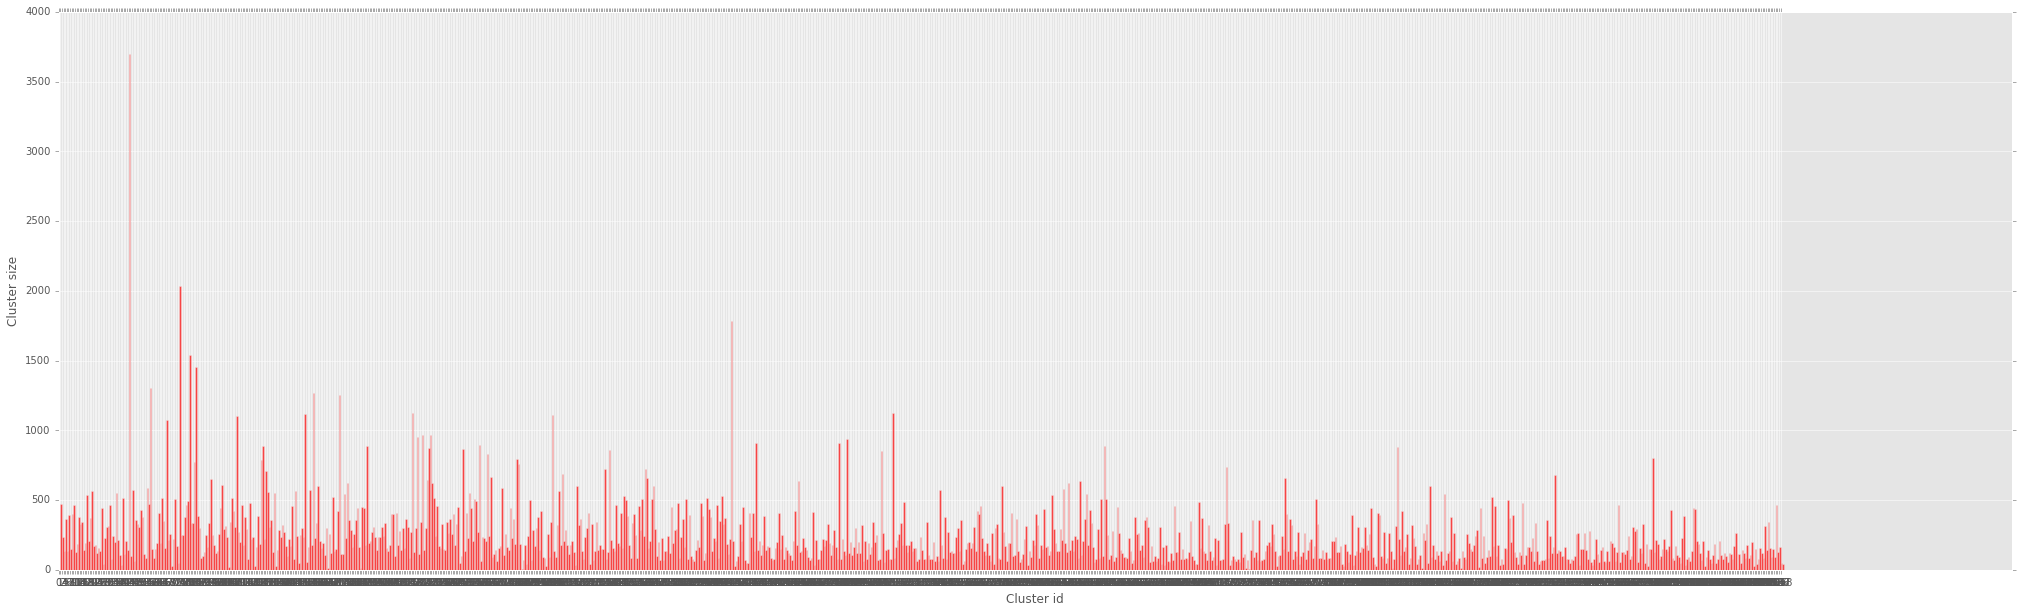

In [9]:
# view samples of product reviews, organized by KMeans cluster results
# viz.view_cluster_samples(10)

# print output to file
# checkout clusters.txt in repo for output
# viz.print_report(30, 'clusters.txt')

# viz the cluster size
# check cluster_size.png in repo for larger version of the png
viz.viz_report()


In [16]:
# from sklearn.metrics import silhouette_samples, silhouette_score

# import matplotlib.cm as cm

# silhouette_score(amazonData.X, labels)

# n_clusters = 10

# # Create a subplot with 1 row and 2 columns
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_size_inches(18, 7)

# # The 1st subplot is the silhouette plot
# # The silhouette coefficient can range from -1, 1 but in this example all
# # lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# # The (n_clusters+1)*10 is for inserting blank space between silhouette
# # plots of individual clusters, to demarcate them clearly.
# ax1.set_ylim([0, amazonData.X.shape[0] + (n_clusters + 1) * 10])
# labels = km.labels_
# centroids = km.cluster_centers_

# # The silhouette_score gives the average value for all the samples.
# # This gives a perspective into the density and separation of the formed
# # clusters

# silhouette_avg = silhouette_score(amazonData.X, labels)
# print("For n_clusters =", n_clusters,
#       "The average silhouette_score is :", silhouette_avg)

# # Compute the silhouette scores for each sample
# sample_silhouette_values = silhouette_samples(amazonData.X, labels)

# y_lower = 10
# for i in range(n_clusters):
#     # Aggregate the silhouette scores for samples belonging to
#     # cluster i, and sort them
#     ith_cluster_silhouette_values = \
#         sample_silhouette_values[labels == i]

#     ith_cluster_silhouette_values.sort()

#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i

#     color = cm.spectral(float(i) / n_clusters)
#     ax1.fill_betweenx(np.arange(y_lower, y_upper),
#                       0, ith_cluster_silhouette_values,
#                       facecolor=color, edgecolor=color, alpha=0.7)

#     # Label the silhouette plots with their cluster numbers at the middle
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     # Compute the new y_lower for next plot
#     y_lower = y_upper + 10  # 10 for the 0 samples

# ax1.set_title("The silhouette plot for the various clusters.")
# ax1.set_xlabel("The silhouette coefficient values")
# ax1.set_ylabel("Cluster label")

# # The vertical line for average silhoutte score of all the values
# ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# ax1.set_yticks([])  # Clear the yaxis labels / ticks
# ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# # 2nd Plot showing the actual clusters formed
# colors = cm.spectral(labels.astype(float) / n_clusters)
# ax2.scatter(amazonData.X[:, 0], amazonData.X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#             c=colors)

# # Draw white circles at cluster centers
# ax2.scatter(centroids[:, 0], centroids[:, 1],
#             marker='o', c="white", alpha=1, s=200)

# for i, c in enumerate(centroids):
#     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

# ax2.set_title("The visualization of the clustered data.")
# ax2.set_xlabel("Feature space for the 1st feature")
# ax2.set_ylabel("Feature space for the 2nd feature")

# plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#               "with n_clusters = %d" % n_clusters),
#              fontsize=14, fontweight='bold')

# plt.show()